<a href="https://colab.research.google.com/github/MarioBolanos/NumericalMethods/blob/main/Runge_Kutta_Adaptativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Adaptive Runge-Kutta Methods

___


This module gives a brief introduction to the consept of "adaptive step size methods" and "embedded Runge-Kutta pairs" for solving ordinary differential equations (ODEs). We are going to solve first-order ODE of the form

$$
\frac{\text{d}}{\text{d}t}y(t) = f(y(t), t).
$$

It is convenient to consider the parameter $t$ as "time" and $y$ as "position" at time $t$. The consept of adaptive step size is easily generalized to e.g. higher order ODEs, much in the same way as the less sophisticated Explicit Euler Method can be generalized to the (Fourth Order) Runge-Kutta Method.

### Basic idea of Adaptive Runge-Kutta Methods
An adaptive Runge-Kutta method is a method that uses two different orders of approximation (often one with order $p$ and one with order $p+1$) to get an estimate of the local truncation error. Thus, it is possible to more or less decide what accuracy we want the solution to have by changing the step size for each iteration. Another advantage of the adaptive step size methods is that we can have more steps where it is needed, and fewer steps elsewhere (an example will follow). However, as is evident, these methods often require more calculations.

By following this idea, we can easily develop pairs of Runge-Kutta (RK) methods (one with order $p$ and one with order $p+1$) that share several of the necessary calculations. This enables us to estimate the local truncation error almost without extra computations. Such pairs are called $\textbf{embedded Runge-Kutta pairs}$.

First, we import the necessary libraries and set some common figure parameters.

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (10, 4), 'axes.grid': True,
             'lines.linewidth': 1.5, 'lines.markersize': 10,
             'font.size': 14}
plt.rcParams.update(newparams)

### Implement functions

It is time to define some functions that are going to calculate two different orders of approximation for the right hand side (RHS) of the ODE, namely $f(y(t),t)$. The following functions are some examples of adaptive Runge-Kutta methods. An algorithm for deriving these methods are given in [2].

In [ ]:
def odesolver12(f, t, y, h):
    """Calculate the next step of an initial value problem (IVP) of
    an ODE with a RHS described by f, with an order 1 approx.
    (Eulers Method) and an order 2 approx. (Midpoint Rule). This is 
    the simplest embedded RK pair.
    Parameters:
        f: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
    Returns:
        q: float. Order 1 approx.
        w: float. Order 2 approx.
    """
    s1 = f(t, y)
    s2 = f(t+h, y+h*s1)
    w = y + h*s1
    q = y + h/2.0*(s1+s2)
    return w, q

def odesolver23(f, t, y, h):
    """Calculate the next step of an IVP of an ODE with a RHS
    described by f, with an order 2 approx. (Explicit Trapezoid 
    Method) and an order 3 approx. (third order RK).
    Parameters:
        f: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    s1 = f(t, y)
    s2 = f(t+h, y+h*s1)
    s3 = f(t+h/2.0, y+h*(s1+s2)/4.0)
    w = y + h*(s1+s2)/2.0
    q = y + h*(s1+4.0*s3+s2)/6.0
    return w, q

def odesolver45(f, t, y, h):
    """Calculate the next step of an IVP of an ODE with a RHS
    described by f, with an order 4 approx. and an order 5 approx.
    Parameters:
        f: function. RHS of ODE.
        t: float. Current time.
        y: float. Current position.
        h: float. Step length.
    Returns:
        q: float. Order 2 approx.
        w: float. Order 3 approx.
    """
    s1 = f(t, y)
    s2 = f(t+h/4.0, y+h*s1/4.0)
    s3 = f(t+3.0*h/8.0, y+3.0*h*s1/32.0+9.0*h*s2/32.0)
    s4 = f(t+12.0*h/13.0, y+1932.0*h*s1/2197.0-7200.0*h*s2/2197.0+7296.0*h*s3/2197.0)
    s5 = f(t+h, y+439.0*h*s1/216.0-8.0*h*s2+3680.0*h*s3/513.0-845.0*h*s4/4104.0)
    s6 = f(t+h/2.0, y-8.0*h*s1/27.0+2*h*s2-3544.0*h*s3/2565+1859.0*h*s4/4104.0-11.0*h*s5/40.0)
    w = y + h*(25.0*s1/216.0+1408.0*s3/2565.0+2197.0*s4/4104.0-s5/5.0)
    q = y + h*(16.0*s1/135.0+6656.0*s3/12825.0+28561.0*s4/56430.0-9.0*s5/50.0+2.0*s6/55.0)
    return w, q

### Decide adaptive stepsize

In the above function definitions $w$ represents the lowest order approximation, and $q$ the higher order approximation. When $h$ is small, a good error estimate for $w$ is

$$
e_{i+1}\approx \left|q_{i+1}-w_ {i+1}\right|.
$$

The idea is that one can perform one step of the computation and then check the error estimate $e_i$, or the relative error $e_i/\left|w_i\right|$. If the error is larger than a chosen tolerance, $TOL$, the stepsize is reduced by a predefined amount, often set to double or halve the step size. 

We always want to minimize our use of computational resources, but still be within the given tolerance. Thus, it would be a good idea to change the step size for the next step only if e.g. the error of the current step is smaller than $TOL/20$. There are however more sophisticated ways to change the step size. 

If we let the tolerance be given by the relative error, $TOL > e_i/\left|w_i\right|$, and assume that $w$ is of order $p$, the error is given by $e_i = \mathcal{O}(h^{p+1})$. By assuming that

$$
e_i\approx \xi h_i^{p+1},
$$

for a constant $\xi$, the step size that is closest to the tolerance is given by

$$
TOL\cdot \left|w_i\right| = \xi h^{p+1}.
$$

This yields

$$
\tilde h = \left(\frac{TOL\cdot |w_i|}{e_i}\right)^{1/{p+1}}h_i,
$$

where $\tilde h$ is the ideal value for the next step size. However, a safety factor is often added, such that the next step size becomes e.g. $h_{i+1}=0.8 \cdot\tilde h$. Moreover, we often use $e_i/\max(w_i, \theta)$ $(\theta>0)$ instead of the relative error to protect againt small $w_i$.

This algorithm for the step size variation is derived for $w_i$, the lowest order approximation. However, since the higher order approximation $q_i$ is available (without extra computation), this is often used to evaluate the next step.

The simplest way to visualize the adaptive step size method is with examples.

### Example 1
First we choose the RHS of the ODE to be

$$
f(y(t),t) = t - 2ty,
$$

which has the analytical solution $\frac{1}{2}(1-e^{-t^2})$. Let us define these functions and get on with solving the ODE using the simplest embedded RK method with an order 1 and an order 2 approximation. We generalize the implementation of the adaptive RK method so that we don't repeat ourselves.

In [ ]:
def RHS1(t, y):
    return t - 2*t*y

def analytical(t, y):
    return 0.5*(1-np.exp(-t**2))

def rk_adaptive(ode, rhs, y0=0.0, t0=0.0, TOL=1e-04, theta=1e-02, tmax=1.0):
    """Perform an adaptive RK method.
    Parameters:
        ode:   function. ODE solver.
        rhs:   function. RHS of ODE.
        y0:    float, optional. Initial position.
        t0:    float, optional. Initial time.
        TOL:   float, optional. Tolerance of relative error.
        theta: float, optional. "Protective" constant.
        tmax:  float, optional. End of calculation interval.
    Returns:
        y:     list. Position.
        t:     list. Time.
        i:     int. Number of iterations
    """
    
    # Allocate lists to store position and time and set
    # initial conditions.
    y = []
    t = []
    y.append(y0)
    t.append(t0)
    
    # Set initial step size and declare iteration integer
    h = 1.0
    i = 0
    
    while (t[i] < tmax):
        # Get two different approximations
        w, q = ode(rhs, t[i], y[i], h)
        # Estimate error
        e = abs((w-q)/max(w, theta))
        # If e larger thant TOL, decrease step length
        if (e > TOL):
            h = 0.8*(TOL*e)**(1/5)*h
            # Get two new approximations
            w, q = ode(rhs, t[i], y[i], h)
            # Estimate new error
            e = abs((w-q)/max(w, theta))
            # If e still larger than TOL, halve step length until False
            while (e > TOL):
                h = h/2.0
                # New approximations
                w, q = ode(rhs, t[i], y[i], h)
                # New error estimate
                e = abs((w-q)/max(w, theta))
        # Store highest order approximation as next y-value
        y.append(q)
        # Store current time + step size as next time
        t.append(t[i] + h)
        # Increment step number
        i += 1
        # Check if e is too small, if so, double step size
        if (e < 0.1*TOL):
            h = h*2.0
    
    return y, t, i

In [ ]:
# Calculate the position as a function of time using the adaptive
# Runge-Kutta odesolver12 defined above
pos, times, iterations = rk_adaptive(odesolver12, RHS1, y0=0.0, t0=0.0, TOL=1e-02, theta=1e-03, tmax=1.0)

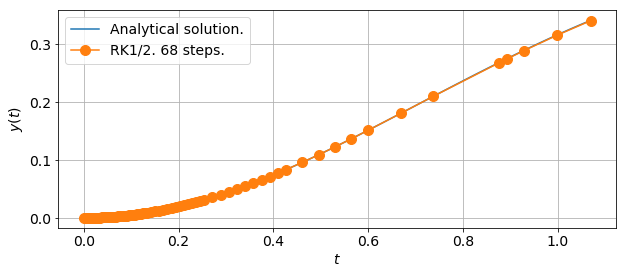

In [ ]:
# Declare plot and plot results
plt.figure()

# Analytical plot
ta = np.linspace(0, times[iterations])
ya = analytical(ta, 0)
plt.plot(ta, ya , label='Analytical solution.')

# RK1/2 plot
plt.plot(times, pos, '-o' , label='RK1/2. %i steps.' % (iterations+1))
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.legend(loc="best");

We observe that the RK method uses 68 steps following the curve nicely, using an increasing step size $h$ as $t$ increases.
### Example 2
We now want to solve the IVP given by

$$
y'(t)=\cos(y(t)\cdot t^2),\quad y(1)=3,
$$

trying out all three embedded RK pair functions defined above.

In [ ]:
def RHS2(t, y):
    return np.cos(y*t**2)

In [ ]:
start12 = time.time()
pos12, time12, iterations12 = rk_adaptive(odesolver12, RHS2, y0=3.0, t0=1.0, tmax=3.0)
print("RK1/2 run time: %.5f s. Iterations: %i." % (time.time() - start12, iterations12 + 1))

start23 = time.time()
pos23, time23, iterations23 = rk_adaptive(odesolver23, RHS2, y0=3.0, t0=1.0, tmax=3.0)
print("RK2/3 run time: %.5f s. Iterations: %i." % (time.time() - start23, iterations23 + 1))

start45 = time.time()
pos45, time45, iterations45 = rk_adaptive(odesolver45, RHS2, y0=3.0, t0=1.0, tmax=3.0)
print("RK4/5 run time: %.5f s. Iterations: %i." % (time.time() - start45, iterations45 + 1))

RK1/2 run time: 0.00265 s. Iterations: 453.
RK2/3 run time: 0.00105 s. Iterations: 110.
RK4/5 run time: 0.00048 s. Iterations: 20.


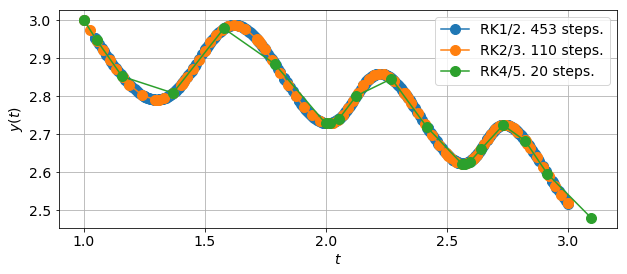

In [ ]:
plt.figure()
plt.plot(time12, pos12, '-o', label='RK1/2. %i steps.' % (iterations12+1))
plt.plot(time23, pos23, '-o', label='RK2/3. %i steps.' % (iterations23+1))
plt.plot(time45, pos45, '-o', label='RK4/5. %i steps.' % (iterations45+1))
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.legend(loc="best");

We observe that the RK4/5 method approximates the function values equally as well as the RK1/2 method does in 433 fewer steps and approximately 1/5 of the time.

